In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy.stats import randint, uniform

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, precision_recall_curve, make_scorer, roc_curve, precision_score, recall_score

from sklearn.model_selection import learning_curve, cross_val_predict, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from joblib import dump


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
X_train = pd.read_csv('/content/drive/MyDrive/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/y_train.csv').squeeze('columns')

In [53]:
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 20)
}

scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs = -1,
                                                          random_state=42),
                                   param_dist,
                                   n_iter=5,
                                   cv=5,
                                   scoring = scoring,
                                   random_state=42,
                                   refit='precision')
random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 113}
Best score: 0.8466510892920738


In [54]:
model_rf = random_search.best_estimator_

probs_rf = cross_val_predict(model_rf, X_train, y_train, cv=5, method='predict_proba')[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_train, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

fpr_rf, tpr_rf, thresholds_rf  = roc_curve(y_train, probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

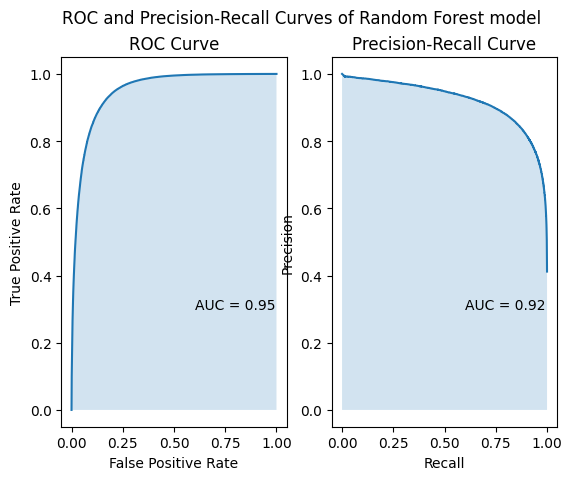

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('ROC and Precision-Recall Curves of Random Forest model')

ax1.plot(fpr_rf, tpr_rf)
ax1.fill_between(fpr_rf, tpr_rf, alpha=0.2)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.text(0.6, 0.3, f'AUC = {roc_auc_rf:.2f}')

ax2.plot(recall_rf, precision_rf)
ax2.fill_between(recall_rf, precision_rf, alpha=0.2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.text(0.6, 0.3, f'AUC = {auc_rf:.2f}')

plt.show()

In [56]:
# Find the optimal threshold
optimal_idx = np.argmax(tpr_rf - fpr_rf)
optimal_threshold = thresholds_rf[optimal_idx]

# Apply the threshold to the predicted probabilities
y_pred = (probs_rf >= optimal_threshold).astype(int)

In [57]:
# Get the refitted model
model_rf = random_search.best_estimator_

# Save the model to a file
dump(model_rf, '/content/drive/MyDrive/random_forest2.joblib')

# Save the threshold value to a file
dump(optimal_threshold, '/content/drive/MyDrive/threshold2.joblib')

['/content/drive/MyDrive/threshold2.joblib']

In [58]:
probs_rf = model_rf.predict_proba(X_test)[:, 1]

y_pred = (probs_rf >= optimal_threshold).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.33684540019407144
Recall: 0.8751219829549151


In [ ]:
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.6),
    'gamma': uniform(0, 10),
    'min_child_weight': randint(1, 10)
}

class_1_weight = 1.5

random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs = -1, sample_weights = np.where(y_train == 1, class_1_weight, 1)),
    param_dist,
    n_iter=5,
    cv=5,
    random_state=42,
    n_jobs=-1,
    scoring=scoring,
    refit='precision'
)

random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


In [34]:
model_xg = random_search.best_estimator_

probs_xg = cross_val_predict(model_xg, X_train, y_train, cv=5, method='predict_proba')[:, 1]
precision_xg, recall_xg, _ = precision_recall_curve(y_train, probs_xg)
auc_xg = auc(recall_xg, precision_xg)

fpr_xg, tpr_xg, thresholds_xg  = roc_curve(y_train, probs_xg)
roc_auc_xg = auc(fpr_xg, tpr_xg)

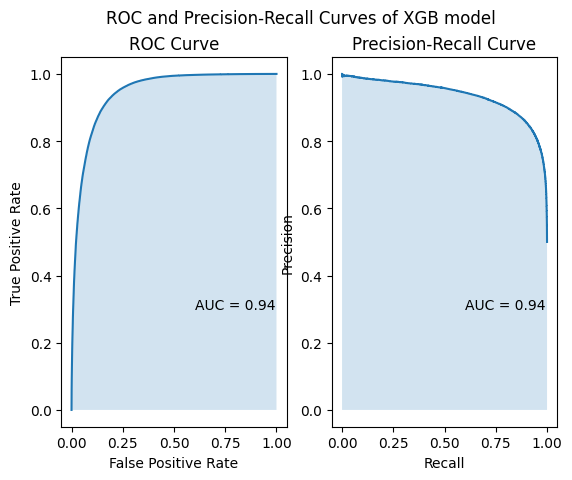

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('ROC and Precision-Recall Curves of XGB model')

ax1.plot(fpr_xg, tpr_xg)
ax1.fill_between(fpr_xg, tpr_xg, alpha=0.2)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.text(0.6, 0.3, f'AUC = {roc_auc_xg:.2f}')

ax2.plot(recall_xg, precision_xg)
ax2.fill_between(recall_xg, precision_xg, alpha=0.2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.text(0.6, 0.3, f'AUC = {auc_xg:.2f}')

plt.show()

In [36]:
# Find the optimal threshold
optimal_idx = np.argmax(tpr_rf - fpr_rf)
optimal_threshold = thresholds_rf[optimal_idx]

# Apply the threshold to the predicted probabilities
y_pred = (probs_rf >= optimal_threshold).astype(int)

In [48]:
probs_xg = model_xg.predict_proba(X_test)[:, 1]

y_pred = (probs_xg >= optimal_threshold).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.3020981903176299
Recall: 0.9060243315334071
